In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger
from rl.processors import WhiteningNormalizerProcessor

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
/Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/U

### Using Forex-v0 with all features available and diffs

In [2]:
from custom_env import ForexV0FullFeature
def env_creator():
    return ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(50, 5000), window_size=24)

env = env_creator()
print(env.df)
obs = env.reset()
obs_shape = obs.shape
nb_actions = env.action_space.n

def buildModel():
    model = Sequential()
    model.add(Flatten(input_shape=(1,) + obs_shape))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(nb_actions, activation='linear'))
    return model
buildModel().summary()

def agent_creator():
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=256, window_length=1)
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, gamma=0.5, enable_double_dqn=False)
    agent.compile(Adam(lr=0.001), metrics=['mae'])
    return agent

                            Open     High      Low    Close        Volume
Time                                                                     
01.01.2017 22:00:00.000  1.05236  1.05253  1.05221  1.05227  1.435400e+08
01.01.2017 23:00:00.000  1.05227  1.05426  1.05226  1.05282  2.531400e+08
02.01.2017 00:00:00.000  1.05283  1.05283  1.05268  1.05281  1.314000e+08
02.01.2017 01:00:00.000  1.05282  1.05286  1.05225  1.05240  2.739400e+08
02.01.2017 02:00:00.000  1.05239  1.05240  1.05164  1.05220  2.581400e+08
...                          ...      ...      ...      ...           ...
29.12.2017 17:00:00.000  1.20224  1.20257  1.20191  1.20218  9.283300e+09
29.12.2017 18:00:00.000  1.20218  1.20242  1.20122  1.20139  7.366750e+09
29.12.2017 19:00:00.000  1.20139  1.20144  1.20073  1.20096  7.205770e+09
29.12.2017 20:00:00.000  1.20098  1.20109  1.19978  1.19982  6.679810e+09
29.12.2017 21:00:00.000  1.19984  1.20130  1.19931  1.20075  4.885530e+09

[6225 rows x 5 columns]
Instructions 

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
130/989 [==>...........................] - ETA: 1s - reward: 1.3731 - cumulative_reward: 125.7623WARNING:tensorflow:From /Users/williamtan/tech/iss/mtech-sls/env/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
989/989 [==============================] - 11s 11ms/step - reward: -11.6905 - cumulative_reward: 978.4453
train 1 completed. took 10.998 seconds, total_reward: 1494.1000000000122 total_profit: 0.9384950985775049
min reward: -139.10000000000088, max reward: 1183.700000000001, mean_reward: 0.3018993736108329


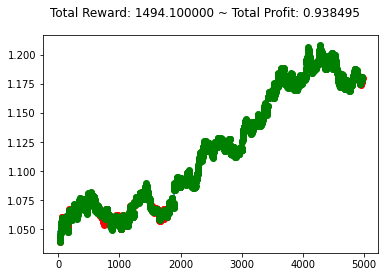

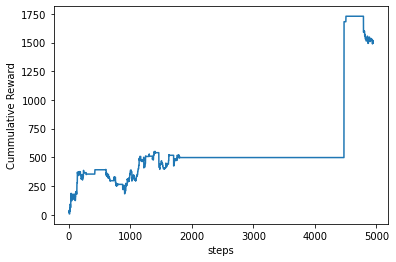

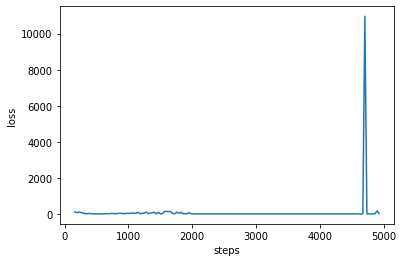

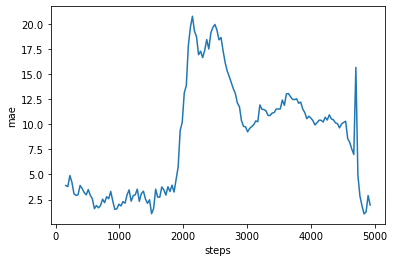

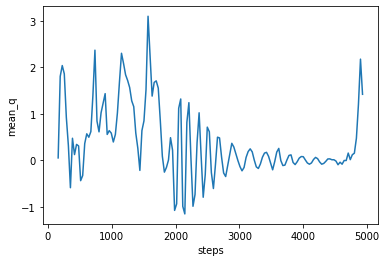

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 12s 12ms/step - reward: 0.5190 - cumulative_reward: 247.0632
train 2 completed. took 24.323 seconds, total_reward: 513.7000000000279 total_profit: 0.8968991602206279
min reward: -97.59999999999769, max reward: 1235.6999999999996, mean_reward: 0.10379874722166658


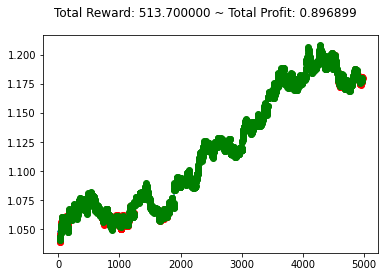

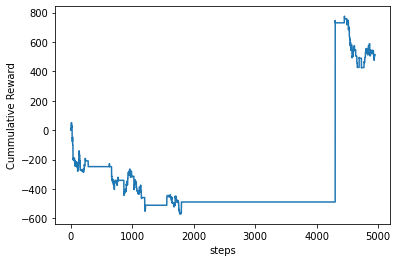

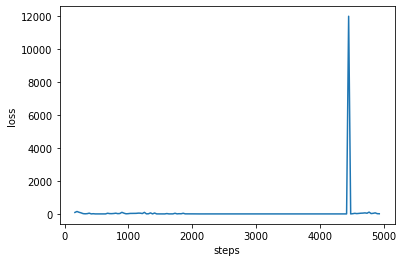

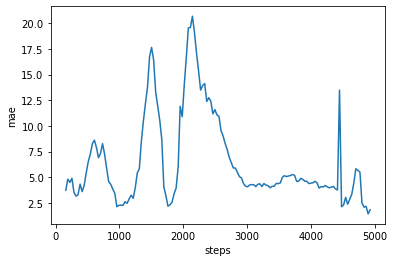

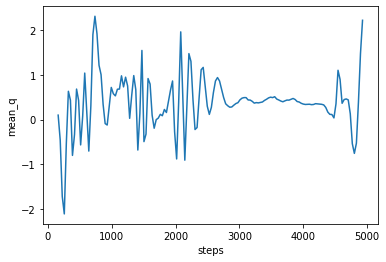

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 12s 13ms/step - reward: 29.1433 - cumulative_reward: -669.1720
train 3 completed. took 38.619 seconds, total_reward: -848.0000000000323 total_profit: 0.7415511405408104
min reward: -129.70000000000147, max reward: 155.200000000002, mean_reward: -0.17134774701960645


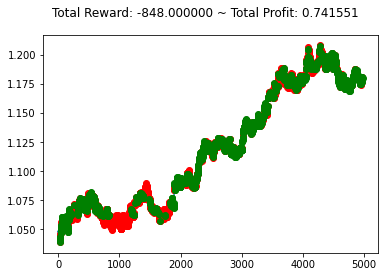

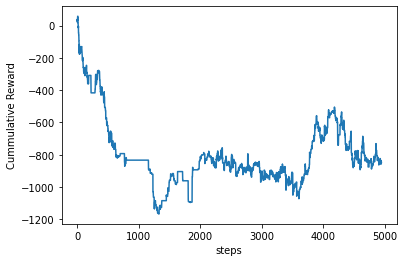

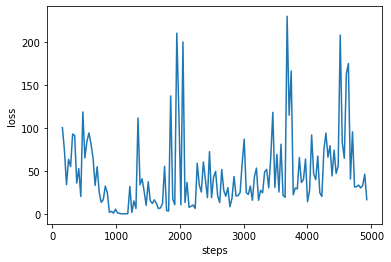

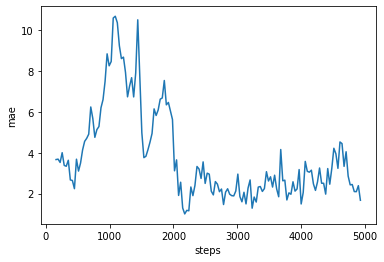

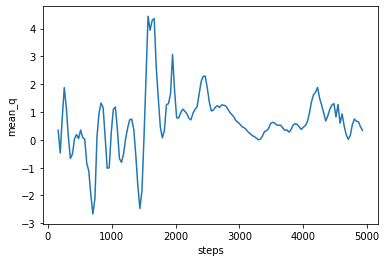

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 14s 14ms/step - reward: 0.8686 - cumulative_reward: 382.9301
train 4 completed. took 54.460 seconds, total_reward: 859.7000000000096 total_profit: 0.9197198373055621
min reward: -143.50000000000085, max reward: 1172.6999999999975, mean_reward: 0.17371186098201852


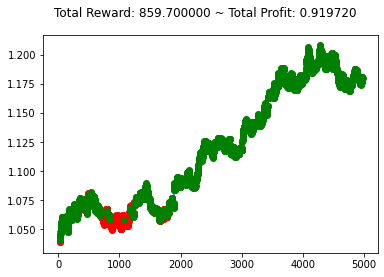

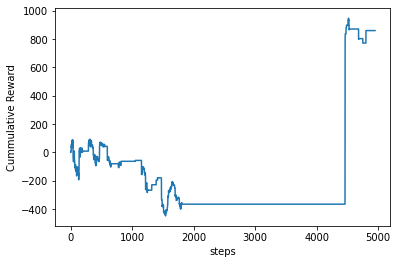

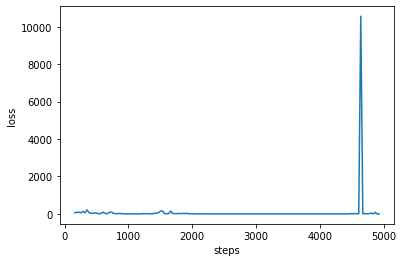

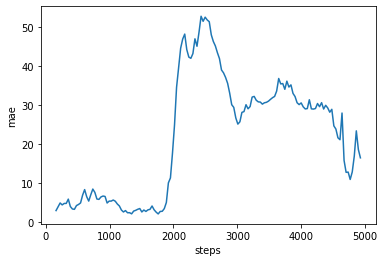

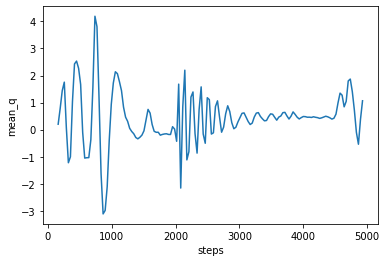

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 14s 14ms/step - reward: 1.3730 - cumulative_reward: 687.6443
train 5 completed. took 70.497 seconds, total_reward: 1359.0000000000312 total_profit: 0.9241869196689334
min reward: -93.99999999999852, max reward: 1100.3999999999992, mean_reward: 0.27460092948070947


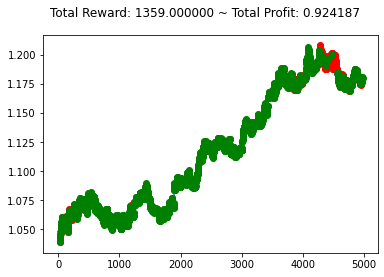

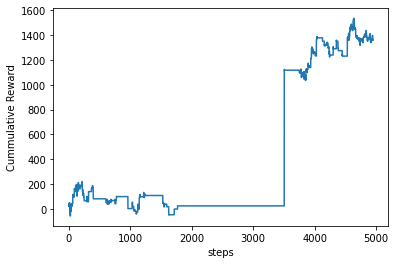

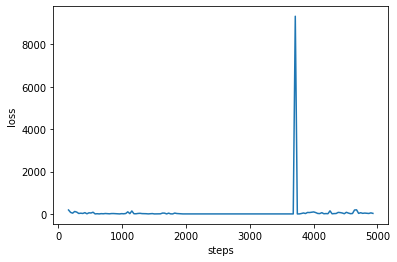

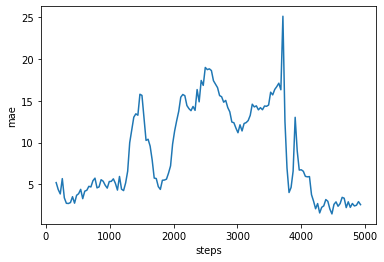

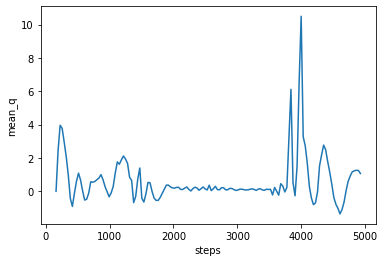

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 15s 15ms/step - reward: 1.8707 - cumulative_reward: 63.9809
train 6 completed. took 87.194 seconds, total_reward: 465.9000000000014 total_profit: 0.8192507077885725
min reward: -147.9000000000008, max reward: 143.90000000000347, mean_reward: 0.09414023034956585


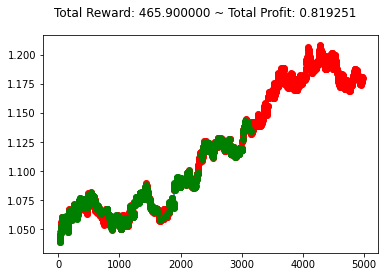

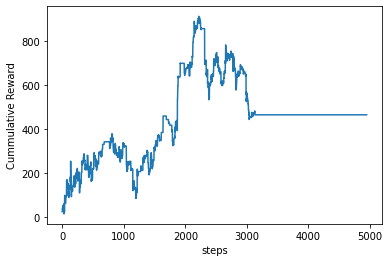

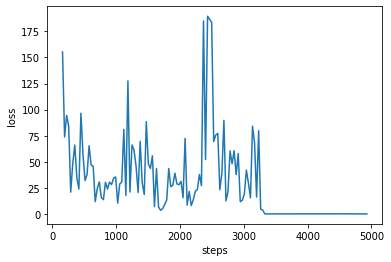

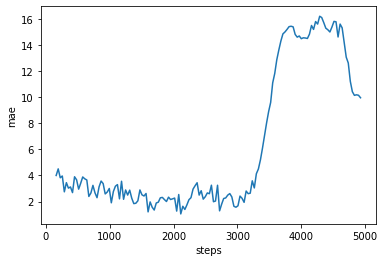

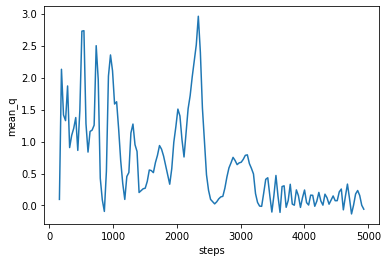

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 15s 15ms/step - reward: 15.1324 - cumulative_reward: -130.7393
train 7 completed. took 104.456 seconds, total_reward: 32.0999999999666 total_profit: 0.8134883902168972
min reward: -156.6999999999985, max reward: 185.10000000000025, mean_reward: 0.00648615881995688


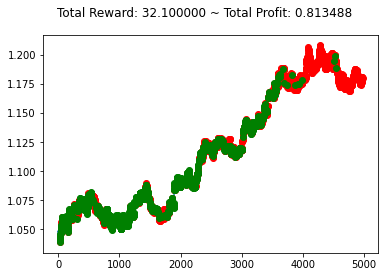

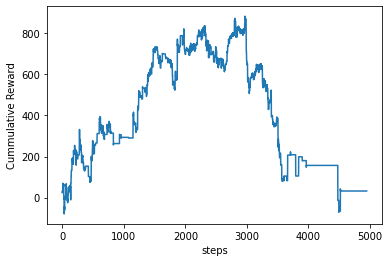

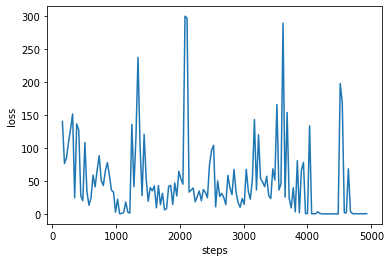

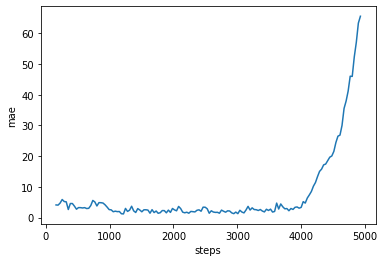

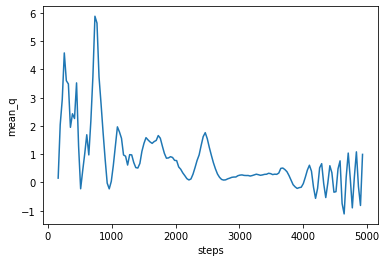

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 17s 17ms/step - reward: -0.4503 - cumulative_reward: -372.9123
train 8 completed. took 124.073 seconds, total_reward: -445.69999999990694 total_profit: 0.7574849085878057
min reward: -168.70000000000164, max reward: 120.5999999999996, mean_reward: -0.09005859769648554


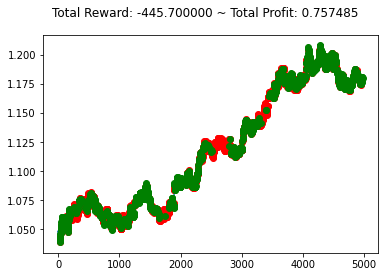

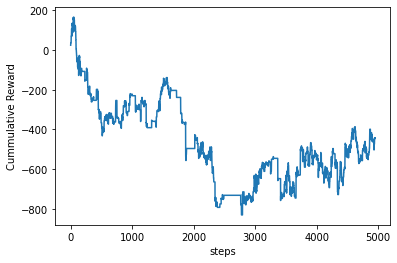

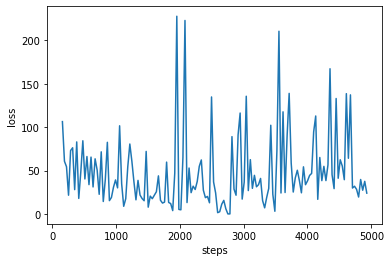

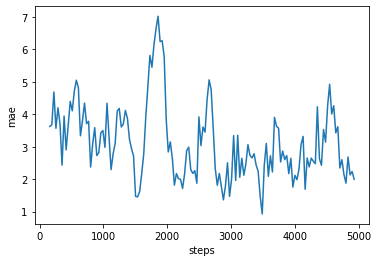

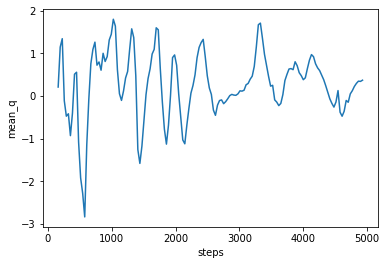

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 16s 16ms/step - reward: 0.9334 - cumulative_reward: 477.8146
train 9 completed. took 142.242 seconds, total_reward: 923.9000000000951 total_profit: 0.9111521475331824
min reward: -111.30000000000307, max reward: 1223.599999999998, mean_reward: 0.18668417862196304


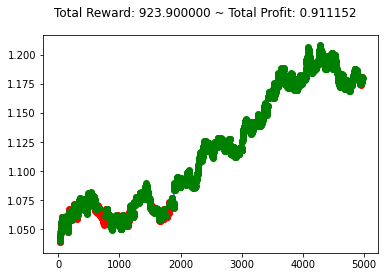

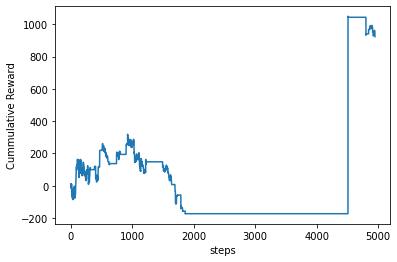

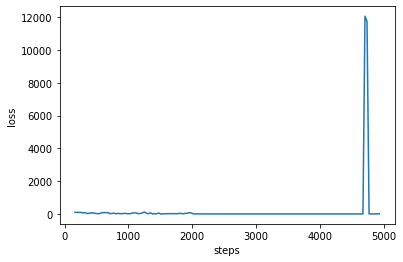

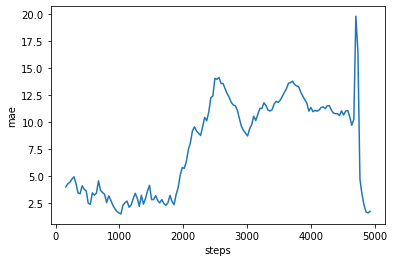

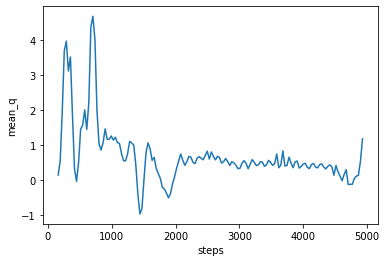

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 15s 16ms/step - reward: -6.3619 - cumulative_reward: 219.6902
train 10 completed. took 160.606 seconds, total_reward: 136.70000000000329 total_profit: 0.809298889765355
min reward: -127.89999999999857, max reward: 154.50000000000185, mean_reward: 0.027621741766014


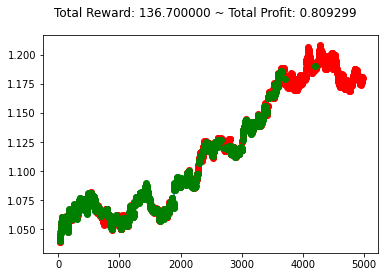

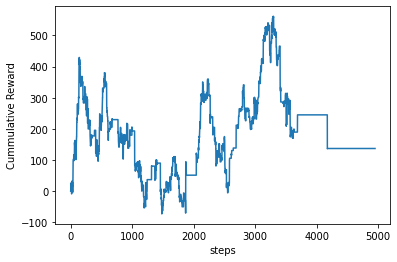

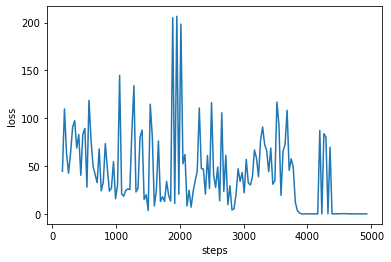

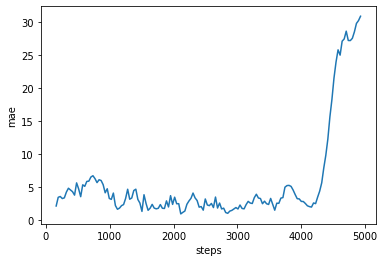

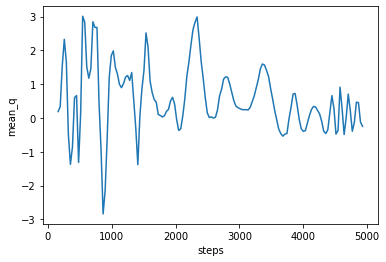

In [3]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="dqn")
e.train(repeat=10)


average of total_reward across trainings: [449.14]


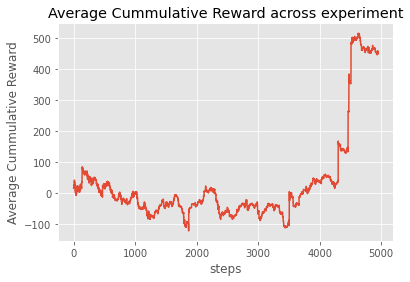

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
198/199 [============================>.] - ETA: 0s - reward: 0.0000e+00 - cumulative_reward: 0.0000e+00Episode 1: reward: 0.000, steps: 999
test completed. total_reward: 0.0 total_profit: 1.0040589181323873
min reward: 0.0, max reward: 0.0, mean_reward: 0.0


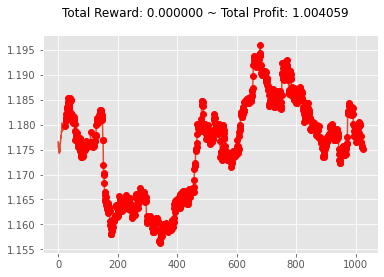

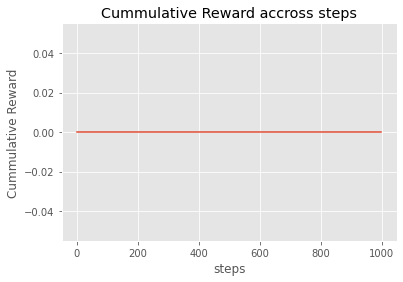

In [4]:
e.process_train_result()
e.test(ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(5000, 6000), window_size=24))

### Double DQN

In [5]:

def agent_creator():
    #processor = EnvProcessor()
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=256, window_length=1)
    #policy = EpsGreedyQPolicy()
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, gamma=0.5, enable_double_dqn=True)
    agent.compile(Adam(lr=0.001), metrics=['mae'])
    return agent

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 17s 17ms/step - reward: -14.2528 - cumulative_reward: 815.0846
train 1 completed. took 18.503 seconds, total_reward: 1036.499999999999 total_profit: 0.7966932242031891
min reward: -154.50000000000185, max reward: 128.8, mean_reward: 0.20943624974742353


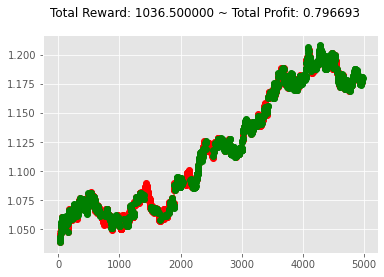

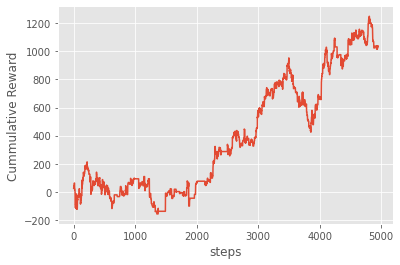

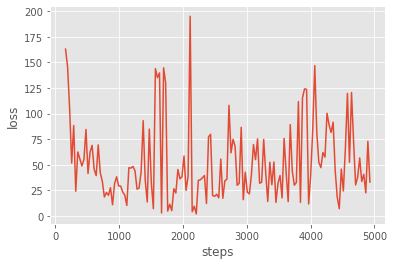

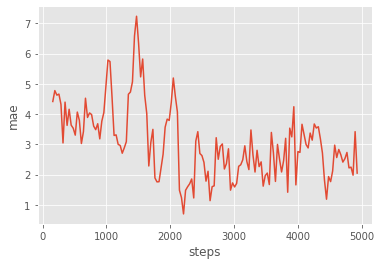

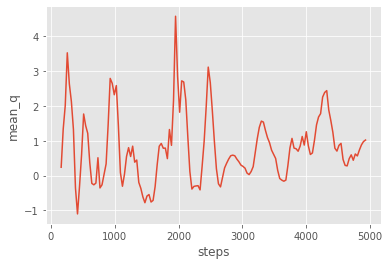

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 18ms/step - reward: -19.8097 - cumulative_reward: -132.3777
train 2 completed. took 39.240 seconds, total_reward: -108.60000000003697 total_profit: 0.8092489132108596
min reward: -126.10000000000011, max reward: 133.09999999999934, mean_reward: -0.02194382703577227


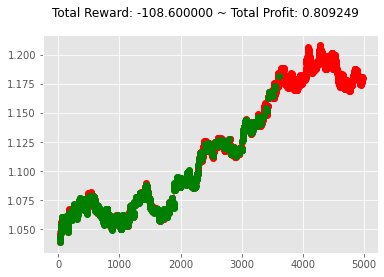

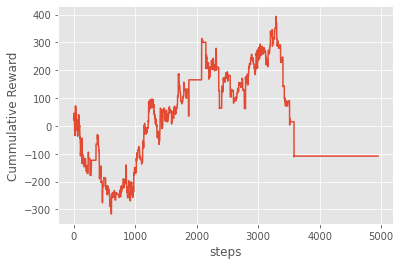

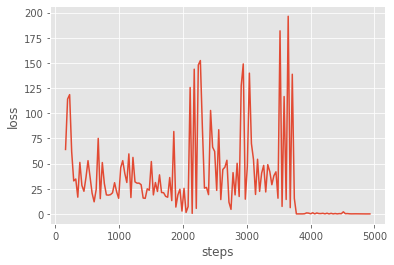

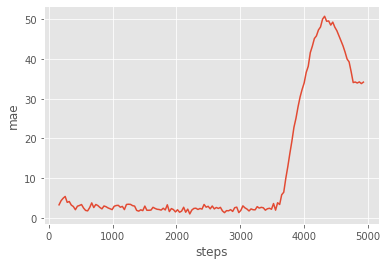

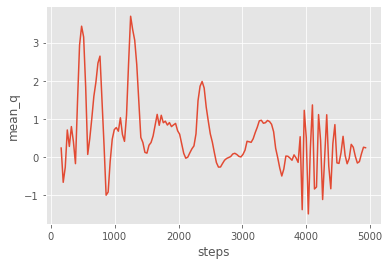

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 18s 18ms/step - reward: -0.4704 - cumulative_reward: -195.5780
train 3 completed. took 60.499 seconds, total_reward: -465.59999999998837 total_profit: 0.8031120215162103
min reward: -168.70000000000164, max reward: 141.0, mean_reward: -0.09407961204283459


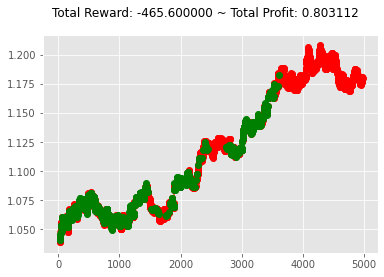

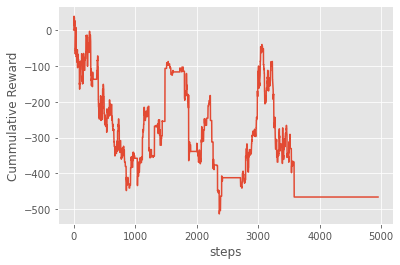

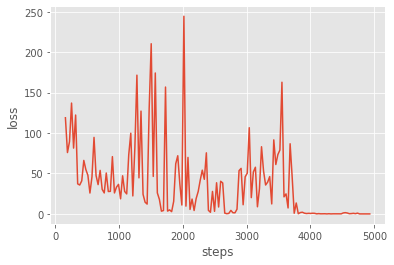

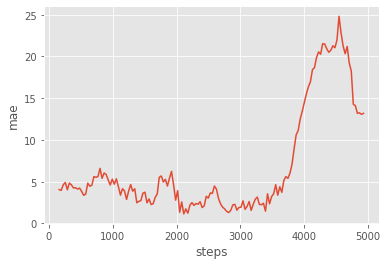

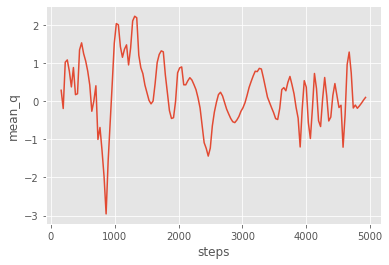

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 20s 20ms/step - reward: -0.4887 - cumulative_reward: -296.1185
train 4 completed. took 83.884 seconds, total_reward: -483.69999999991586 total_profit: 0.773657675996724
min reward: -138.79999999999893, max reward: 180.7000000000003, mean_reward: -0.09773691654878074


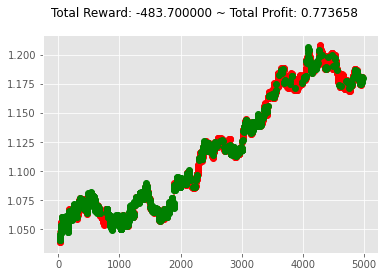

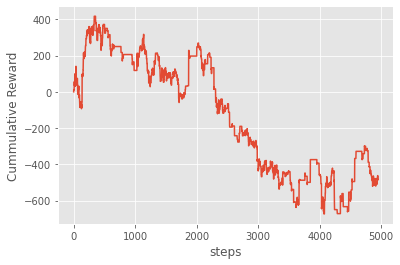

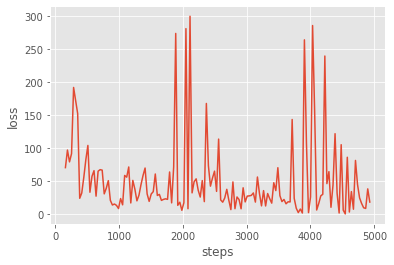

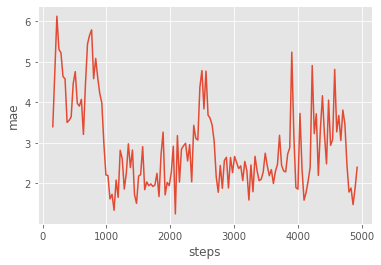

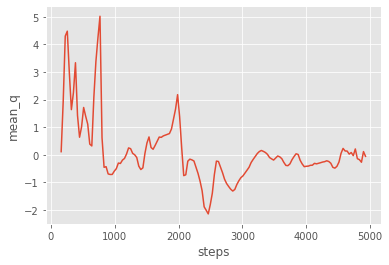

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 20s 20ms/step - reward: -0.1326 - cumulative_reward: -123.6462
train 5 completed. took 107.389 seconds, total_reward: -131.2000000000381 total_profit: 0.8558301450886701
min reward: -273.60000000000053, max reward: 469.5999999999989, mean_reward: -0.02651040614266278


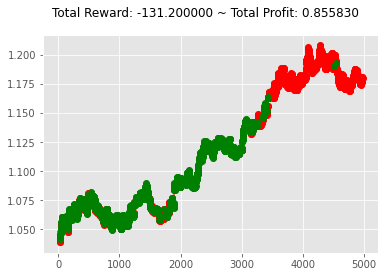

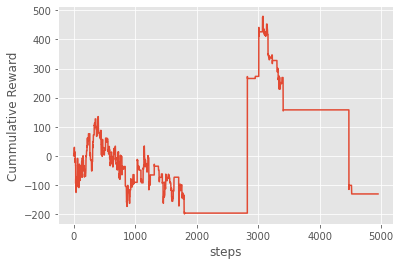

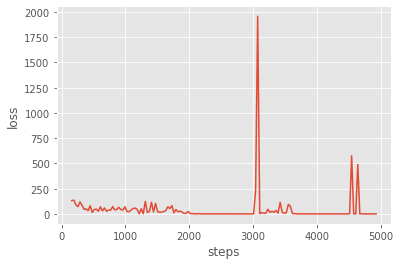

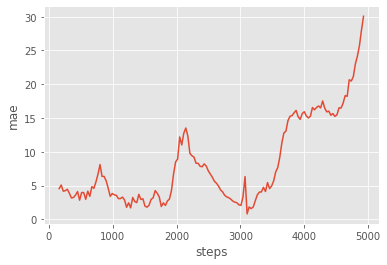

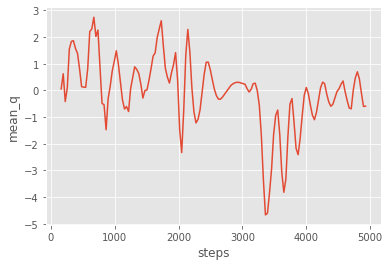

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 20s 21ms/step - reward: -0.0141 - cumulative_reward: -123.2641
train 6 completed. took 132.088 seconds, total_reward: -14.00000000005419 total_profit: 0.8324011315799635
min reward: -85.69999999999966, max reward: 124.29999999999941, mean_reward: -0.0028288543140137785


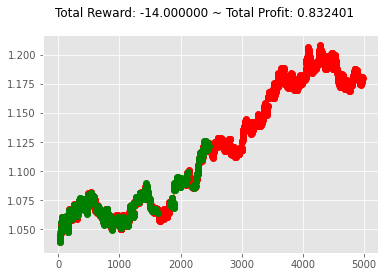

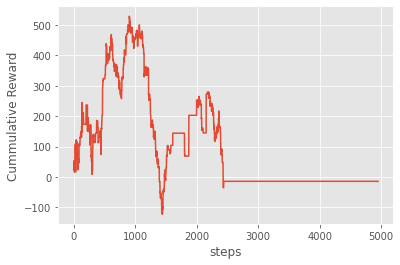

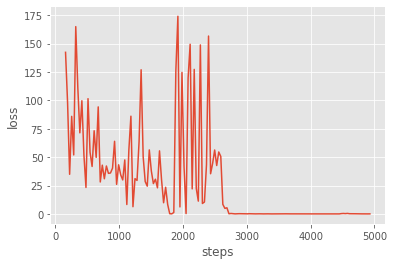

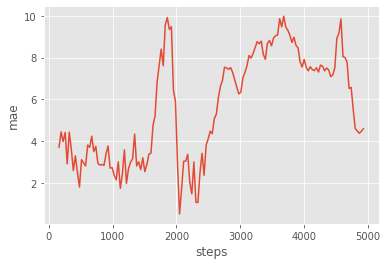

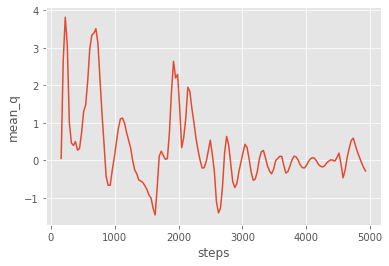

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 22s 22ms/step - reward: 0.5220 - cumulative_reward: 177.1090
train 7 completed. took 158.060 seconds, total_reward: 516.6999999999389 total_profit: 0.9097313178676588
min reward: -144.49999999999852, max reward: 1171.9999999999998, mean_reward: 0.10440493028893491


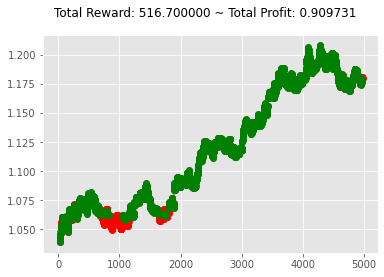

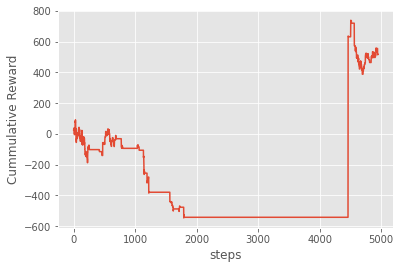

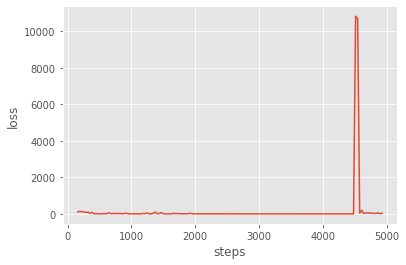

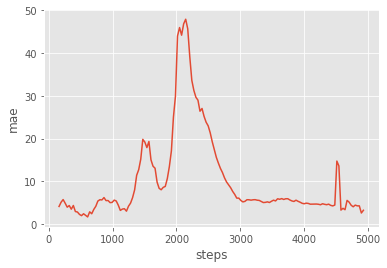

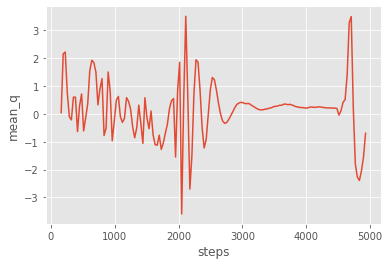

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 24s 24ms/step - reward: 12.8540 - cumulative_reward: 145.5863
train 8 completed. took 186.406 seconds, total_reward: 746.299999999968 total_profit: 0.83409478609169
min reward: -69.10000000000194, max reward: 324.09999999999826, mean_reward: 0.15079814103858719


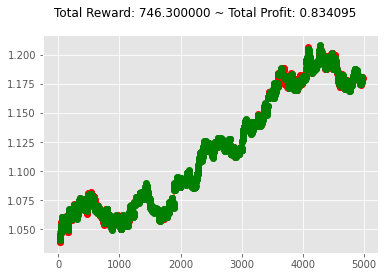

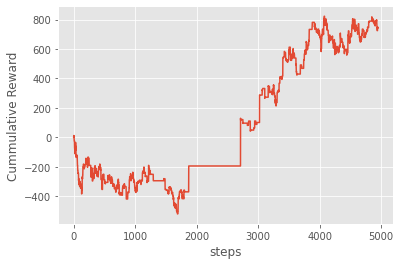

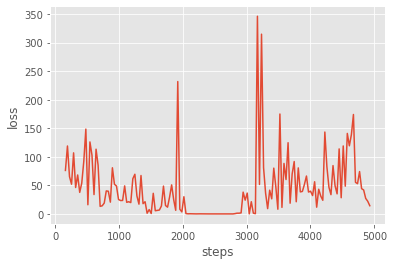

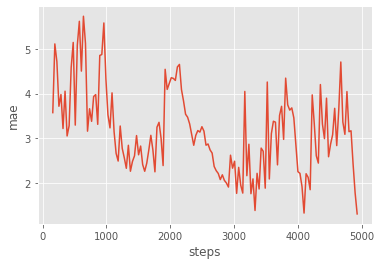

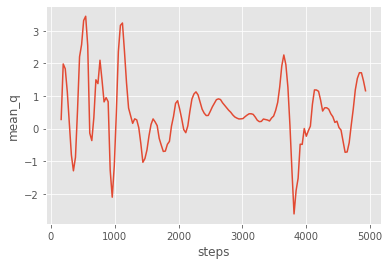

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 24s 25ms/step - reward: -3.9676 - cumulative_reward: 24.0133
train 9 completed. took 216.049 seconds, total_reward: -165.8999999999282 total_profit: 0.8147255075883981
min reward: -195.19999999999982, max reward: 77.60000000000211, mean_reward: -0.03352192362091902


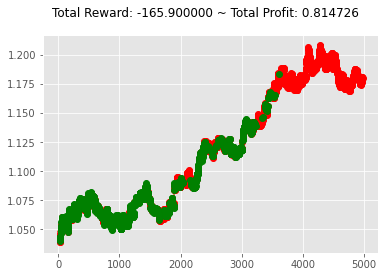

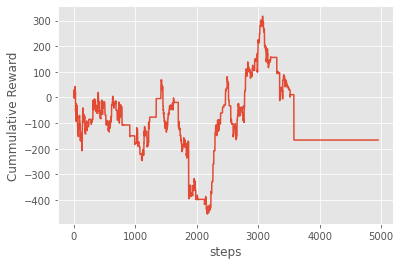

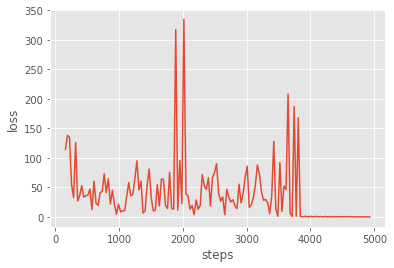

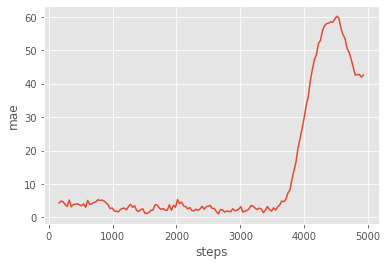

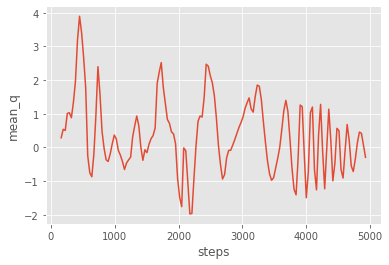

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 25s 25ms/step - reward: -36.3765 - cumulative_reward: -432.4342
train 10 completed. took 247.054 seconds, total_reward: -174.69999999993013 total_profit: 0.8035427063478037
min reward: -168.8999999999985, max reward: 168.4999999999981, mean_reward: -0.03530006061829261


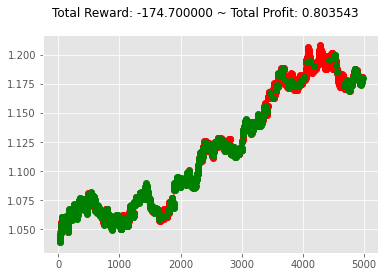

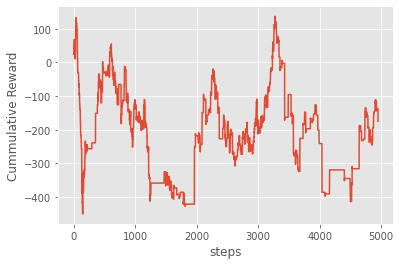

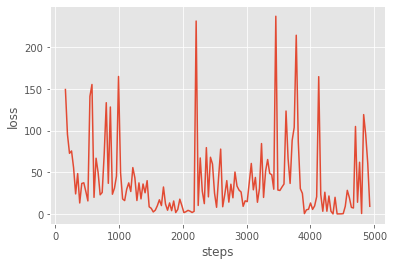

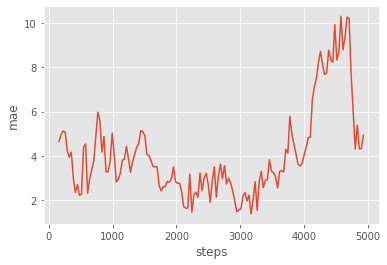

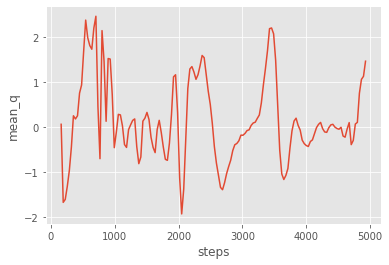

In [6]:
e = Evaluator(agent_creator, env_creator, name="doubledqn")
e.train(repeat=10)

average of total_reward across trainings: [75.58]


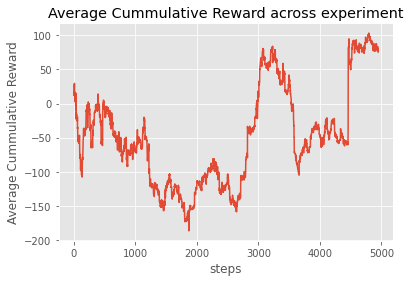

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
190/199 [===========================>..] - ETA: 0s - reward: -7.2689 - cumulative_reward: -77.8758Episode 1: reward: -164.500, steps: 999
test completed. total_reward: -164.50000000000958 total_profit: 0.9762284021518828
min reward: -147.10000000000002, max reward: 66.90000000000308, mean_reward: -0.16466466466467425


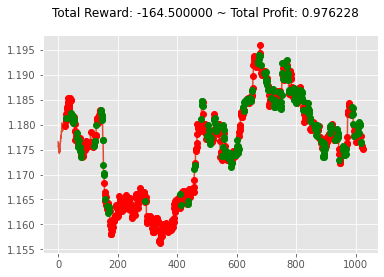

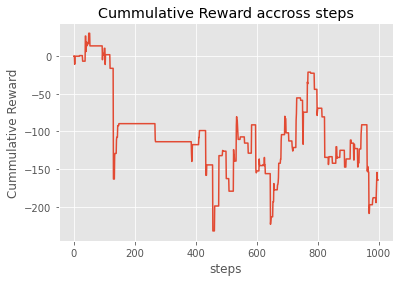

In [7]:
e.process_train_result()
e.test(ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(5000, 6000), window_size=24))

### Dueling DQN

starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 25s 26ms/step - reward: -8.1291 - cumulative_reward: 116.6591
train 1 completed. took 28.305 seconds, total_reward: 268.10000000000053 total_profit: 0.8360017195422383
min reward: -161.69999999999794, max reward: 160.79999999999873, mean_reward: 0.05417256011315428


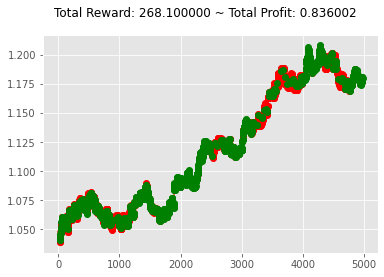

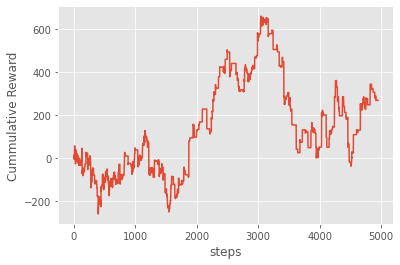

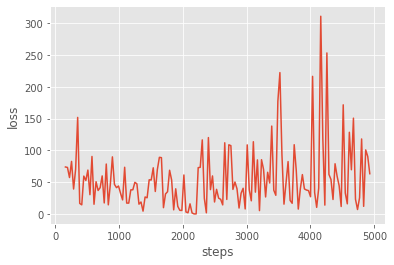

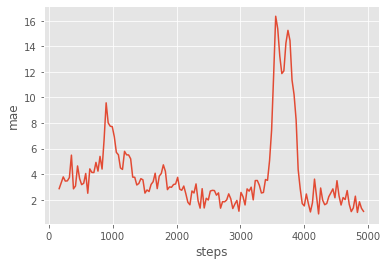

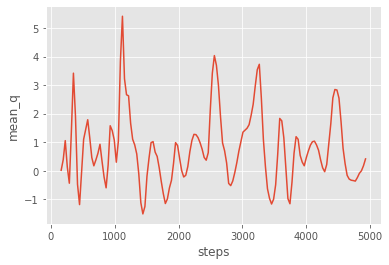

starting train 2
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 26s 26ms/step - reward: 20.3014 - cumulative_reward: -442.6208
train 2 completed. took 60.327 seconds, total_reward: -493.4999999999838 total_profit: 0.8180441521587208
min reward: -172.40000000000146, max reward: 155.40000000000109, mean_reward: -0.09971711456859644


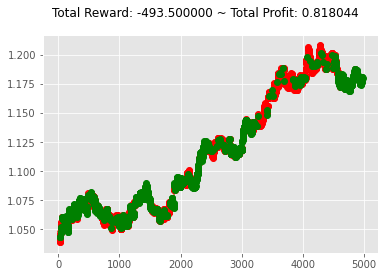

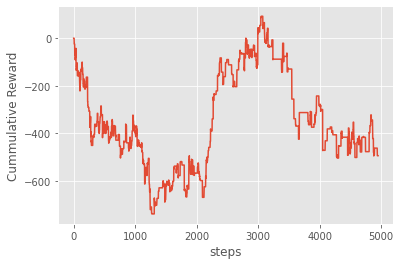

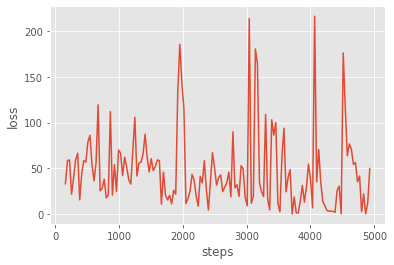

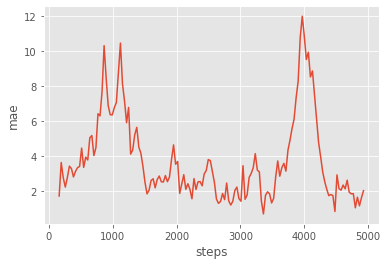

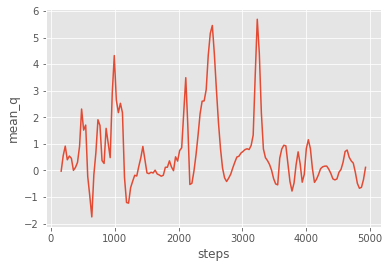

starting train 3
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 26s 27ms/step - reward: 19.0174 - cumulative_reward: -706.5589
train 3 completed. took 93.121 seconds, total_reward: -576.6999999999873 total_profit: 0.8407028276847516
min reward: -245.40000000000006, max reward: 137.39999999999864, mean_reward: -0.11652859163467111


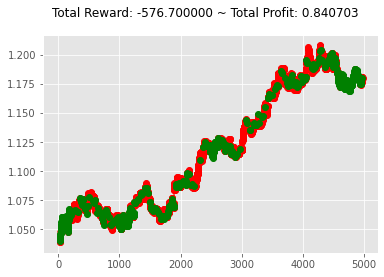

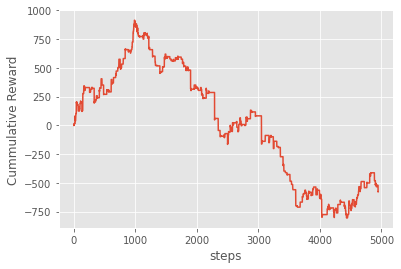

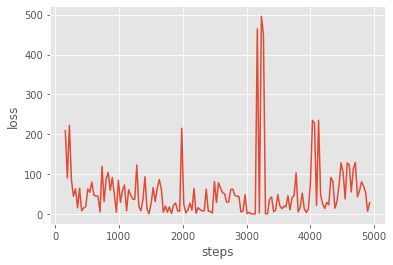

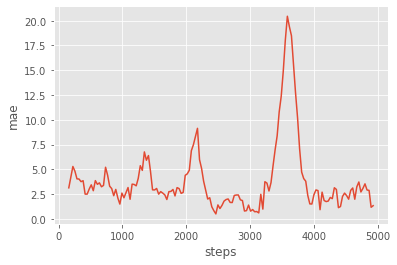

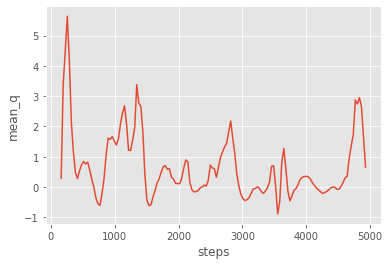

starting train 4
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 27s 27ms/step - reward: -11.5401 - cumulative_reward: -792.1287
train 4 completed. took 126.248 seconds, total_reward: -1128.5000000000184 total_profit: 0.7794044486846854
min reward: -157.59999999999997, max reward: 157.09999999999891, mean_reward: -0.2280258638108746


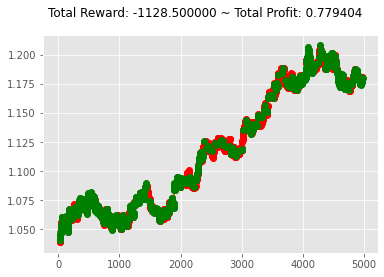

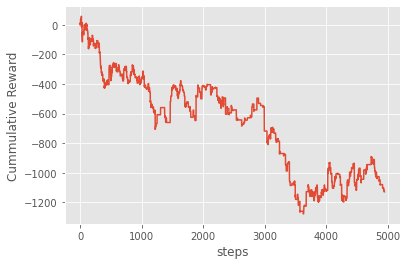

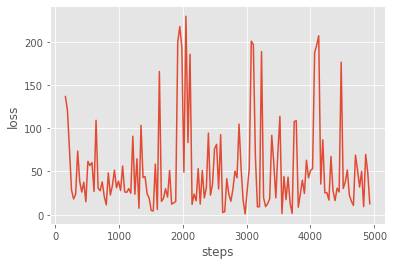

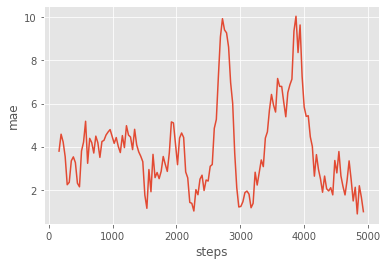

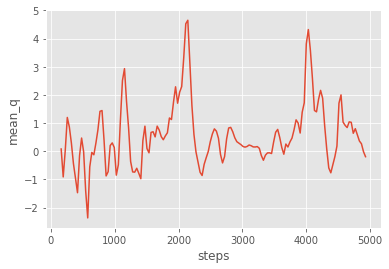

starting train 5
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 28s 28ms/step - reward: -21.3818 - cumulative_reward: 470.1331
train 5 completed. took 160.421 seconds, total_reward: 809.899999999972 total_profit: 0.8794948393916677
min reward: -183.20000000000113, max reward: 183.60000000000153, mean_reward: 0.163649222065058


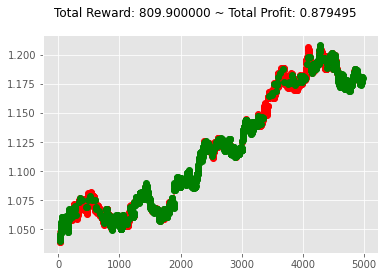

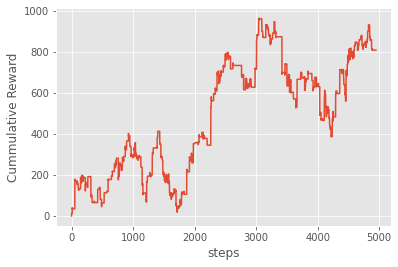

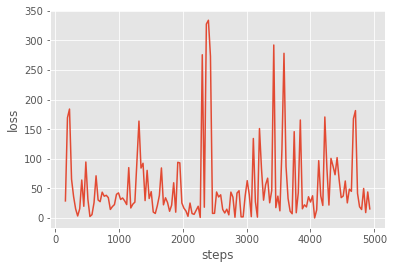

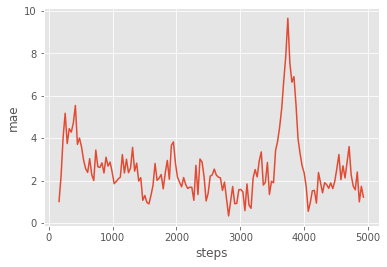

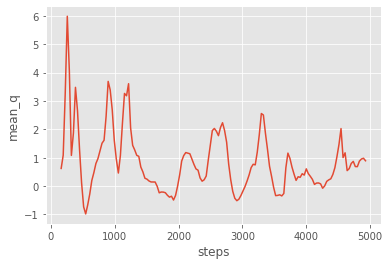

starting train 6
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 28s 29ms/step - reward: -26.2797 - cumulative_reward: 261.0356
train 6 completed. took 195.456 seconds, total_reward: 910.8999999998124 total_profit: 0.8214304033333885
min reward: -136.10000000000122, max reward: 180.40000000000055, mean_reward: 0.18405738533033186


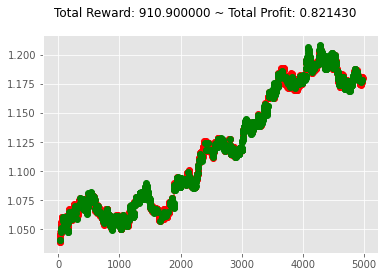

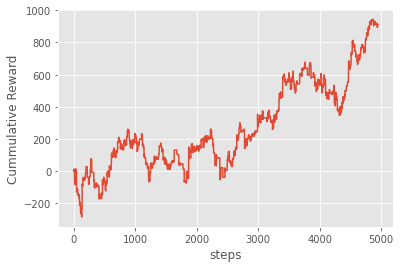

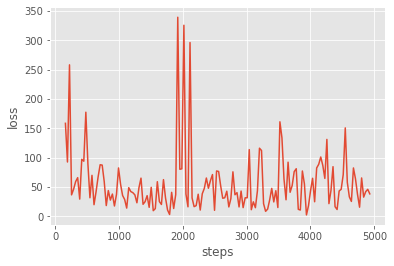

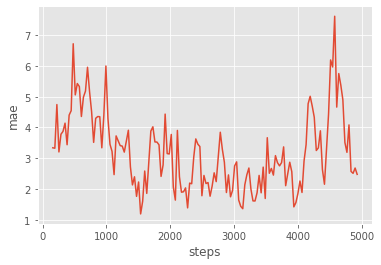

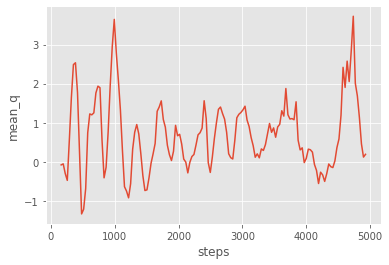

starting train 7
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 30s 30ms/step - reward: -8.2266 - cumulative_reward: -1052.5974
train 7 completed. took 231.986 seconds, total_reward: -1411.999999999982 total_profit: 0.7964368694284822
min reward: -126.20000000000076, max reward: 180.8999999999994, mean_reward: -0.2853101636694245


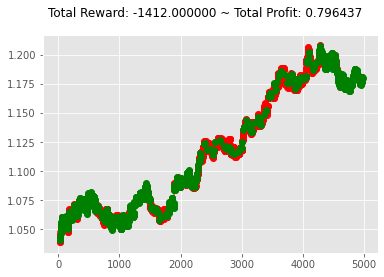

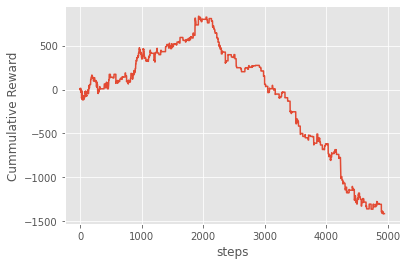

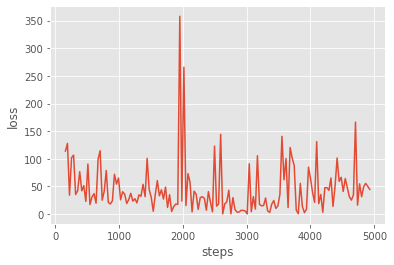

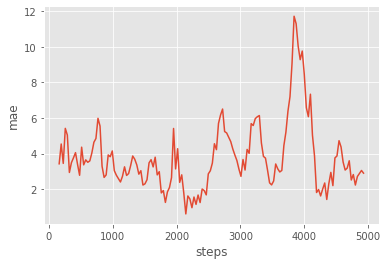

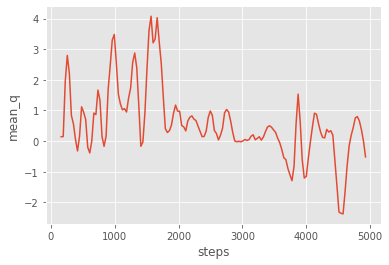

starting train 8
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 30s 30ms/step - reward: -1.8456 - cumulative_reward: -954.2419
train 8 completed. took 269.678 seconds, total_reward: -1826.7999999999895 total_profit: 0.7840745069093692
min reward: -160.19999999999922, max reward: 94.40000000000114, mean_reward: -0.3691250757728813


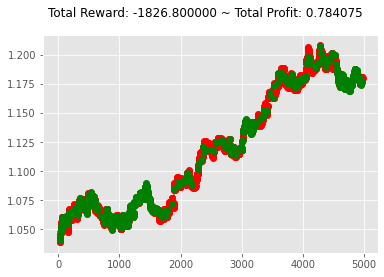

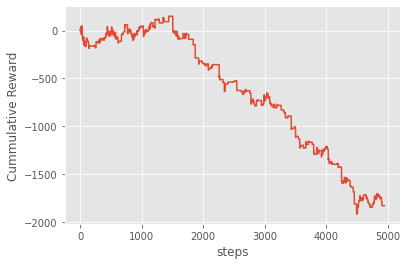

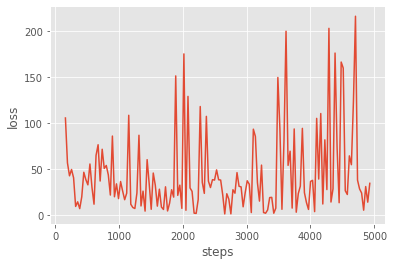

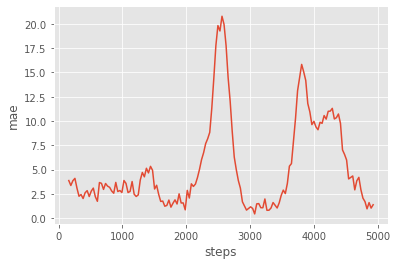

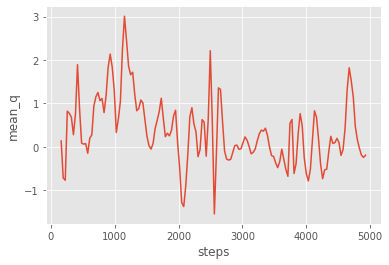

starting train 9
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 31s 31ms/step - reward: -0.5078 - cumulative_reward: -682.9405
train 9 completed. took 307.814 seconds, total_reward: -502.60000000002253 total_profit: 0.827489842717202
min reward: -186.2000000000008, max reward: 154.90000000000003, mean_reward: -0.10155586987270611


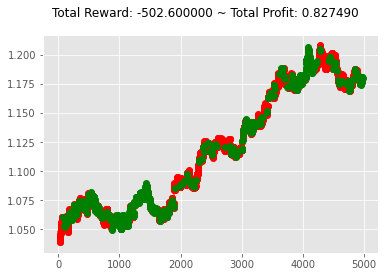

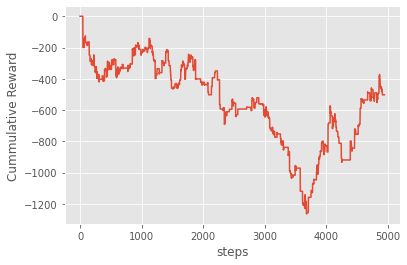

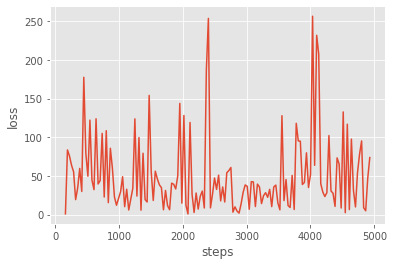

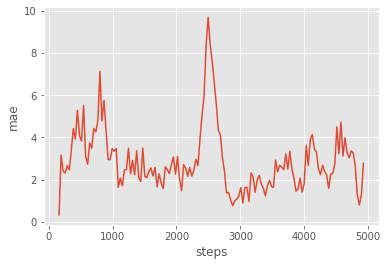

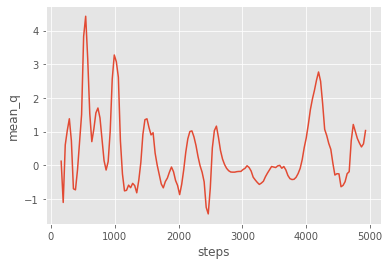

starting train 10
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
989/989 [==============================] - 31s 32ms/step - reward: 13.8540 - cumulative_reward: 104.9060
train 10 completed. took 346.866 seconds, total_reward: 647.3000000000422 total_profit: 0.8630434733570211
min reward: -216.09999999999906, max reward: 164.29999999999944, mean_reward: 0.13079409981815363


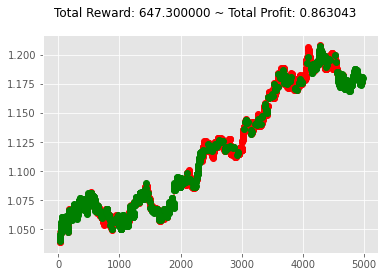

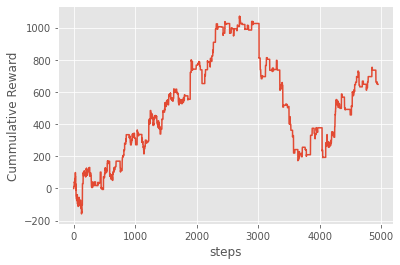

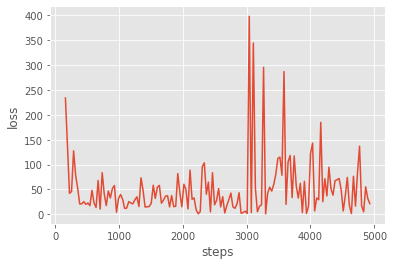

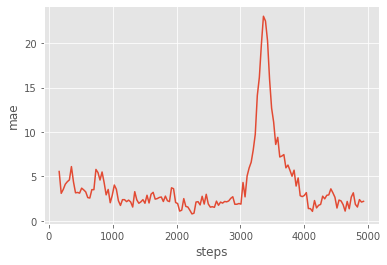

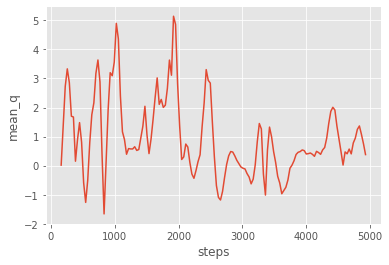

In [8]:
def agent_creator():
    processor = WhiteningNormalizerProcessor()
    memory = SequentialMemory(limit=256, window_length=1)
    policy = EpsGreedyQPolicy()
    agent = DQNAgent(model=buildModel(), nb_actions=nb_actions, memory=memory, nb_steps_warmup=128, policy=policy, batch_size=64, processor=processor, 
                   target_model_update=1e-2, train_interval=32, enable_double_dqn=False, gamma=0.5, enable_dueling_network=True)
    agent.compile(Adam(lr=0.001), metrics=['mae'])
    return agent
e = Evaluator(agent_creator, env_creator, name="dueling_dqn")
e.train(repeat=10)


average of total_reward across trainings: [-330.39]


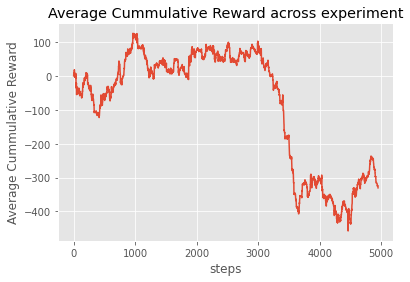

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
181/199 [==========================>...] - ETA: 0s - reward: 5.5880 - cumulative_reward: -297.3636Episode 1: reward: -696.300, steps: 999
test completed. total_reward: -696.3000000000385 total_profit: 0.9620780225859218
min reward: -121.6000000000017, max reward: 80.59999999999957, mean_reward: -0.6969969969970355


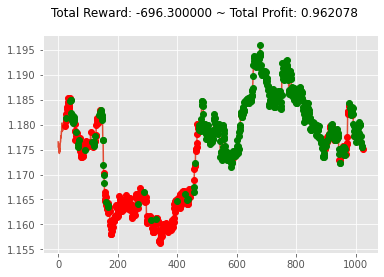

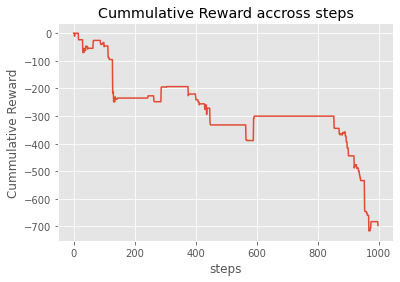

In [9]:
e.process_train_result()
e.test(ForexV0FullFeature(df=FOREX_EURUSD_1H_ASK, frame_bound=(5000, 6000), window_size=24))